In [57]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [58]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [59]:
class Atanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()
        self.alpha = nn.Parameter(torch.tensor(0.9))

    def forward(self, x):
        return self.tanh(self.alpha * x)

In [60]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=20.0):
        super(FourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return torch.cat([x, fourier], dim=-1) 

In [61]:
class Gate1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.atanh = Atanh()
    
    def forward(self, x):
        return self.atanh(self.linear(x))

In [62]:
class Gate2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.atanh = Atanh()
    
    def forward(self, x):
        return self.atanh(self.linear(x))

In [63]:
class Network(nn.Module):
    def __init__(self, num_input=2, fourier_features=10, layers=[64, 64, 64], num_output=3, scale=20.0):
        super().__init__()
        self.fourier = FourierFeatures(num_input, fourier_features, scale)
        input_size = num_input + 2*fourier_features
        self.input_layer = nn.Linear(input_size, layers[0])
        self.z_layers = nn.ModuleList()
        self.gate1 = Gate1(input_size, layers[0])
        self.gate2 = Gate2(input_size, layers[0])
        for i in range(len(layers)-1):
            self.z_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], num_output)
    def forward(self, x):
        x = self.fourier(x)
        U = self.gate1(x)
        V = self.gate2(x)
        h = torch.tanh(self.input_layer(x))
        for z_layer in self.z_layers:
            Z = torch.tanh(z_layer(h))
            h = (1 - Z) * U + Z * V
        return self.output_layer(h)

In [68]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)
        #initialize_weights(self.network)        
        # Assumptions
        self.rho=1.0
        self.nu=0.0003125
        self.u0=1.0

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T

        # Transfer tensor to GPU
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=1.0,
            max_iter = 5000,
            max_eval = 5000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        self.loss_history = []
    def loss_f(self):
        # Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Network prediction
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:, 0].reshape(len(self.x), len(self.y))
        self.v_P = self.uvp_P[:, 1].reshape(len(self.x), len(self.y))
        self.p_P = self.uvp_P[:, 2].reshape(len(self.x), len(self.y))

        # Apply hard boundary conditions
        self.u_P[0, :], self.u_P[-1, :], self.u_P[:, 0], self.u_P[:, -1] = 0.0, 0.0, 0.0, self.u0
        self.v_P[0, :], self.v_P[-1, :], self.v_P[:, 0], self.v_P[:, -1] = 0.0, 0.0, 0.0, 0.0

        dx = self.x[1] - self.x[0]
        dy = self.y[1] - self.y[0]
        
        #Second order diff
        def central_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - arr[:-2, :]) / (2 * dx)
            return res

        def central_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - arr[:, :-2]) / (2 * dy)
            return res

        def second_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - 2 * arr[1:-1, :] + arr[:-2, :]) / (dx ** 2)
            return res

        def second_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - 2 * arr[:, 1:-1] + arr[:, :-2]) / (dy ** 2)
            return res
        du_dx = central_diff_x(self.u_P)
        du_dy = central_diff_y(self.u_P)
        du_dxx = second_diff_x(self.u_P)
        du_dyy = second_diff_y(self.u_P)

        dv_dx = central_diff_x(self.v_P)
        dv_dy = central_diff_y(self.v_P)
        dv_dxx = second_diff_x(self.v_P)
        dv_dyy = second_diff_y(self.v_P)
    
        dp_dx = central_diff_x(self.p_P)
        dp_dy = central_diff_y(self.p_P)

        # Extract interior points
        slice_in = slice(1, -1)
        u_int = self.u_P[slice_in, slice_in]
        v_int = self.v_P[slice_in, slice_in]
        du_dx_int = du_dx[slice_in, slice_in]
        du_dy_int = du_dy[slice_in, slice_in]
        du_dxx_int = du_dxx[slice_in, slice_in]
        du_dyy_int = du_dyy[slice_in, slice_in]
        dv_dx_int = dv_dx[slice_in, slice_in]
        dv_dy_int = dv_dy[slice_in, slice_in]
        dv_dxx_int = dv_dxx[slice_in, slice_in]
        dv_dyy_int = dv_dyy[slice_in, slice_in]
        dp_dx_int = dp_dx[slice_in, slice_in]
        dp_dy_int = dp_dy[slice_in, slice_in]

        # Compute PDE residuals
        con_equ = du_dx_int + dv_dy_int
        u_eqn = u_int * du_dx_int + v_int * du_dy_int + dp_dx_int / self.rho - self.nu * (du_dxx_int + du_dyy_int)
        v_eqn = u_int * dv_dx_int + v_int * dv_dy_int + dp_dy_int / self.rho - self.nu * (dv_dxx_int + dv_dyy_int)

        # Calculate loss
        self.loss = self.criterion(con_equ.reshape(-1), torch.zeros_like(con_equ).reshape(-1)) + \
                    self.criterion(u_eqn.reshape(-1), torch.zeros_like(u_eqn).reshape(-1)) + \
                    self.criterion(v_eqn.reshape(-1), torch.zeros_like(v_eqn).reshape(-1))

        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T

        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        plt.figure(figsize=(6, 5))
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        cbar = plt.colorbar(contour1)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))      
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("u velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/u_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(6, 5))
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        cbar = plt.colorbar(contour2)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X ", fontsize=13)
        plt.ylabel("Y ", fontsize=13)
        plt.title("v velocity", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/v_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(6, 5))
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        cbar = plt.colorbar(contour3)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("Pressure", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/pressure_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(5, 5))
        plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color='red', cmap='autumn', linewidth=0.5, density=2.0, arrowsize=0)
        plt.xlabel("X", fontsize=13)
        plt.ylabel("Y", fontsize=13)
        plt.title("streamline", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/streamline_plot.png", dpi=300)
        plt.show()
        plt.close()

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()
        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/loss_history5.csv", index=False)

Iteration 0, Loss: 0.000004
Iteration 10, Loss: 0.000303
Iteration 20, Loss: 0.000060
Iteration 30, Loss: 0.000008
Iteration 40, Loss: 0.000011
Iteration 50, Loss: 0.000007
Iteration 60, Loss: 0.000004
Iteration 70, Loss: 0.000003
Iteration 80, Loss: 0.000003
Iteration 90, Loss: 0.000003
Iteration 100, Loss: 0.000003
Iteration 110, Loss: 0.000003
Iteration 120, Loss: 0.000003
Iteration 130, Loss: 0.000003
Iteration 140, Loss: 0.000003
Iteration 150, Loss: 0.000003
Iteration 160, Loss: 0.000003
Iteration 170, Loss: 0.000003
Iteration 180, Loss: 0.000003
Iteration 190, Loss: 0.000003
Iteration 200, Loss: 0.000003
Iteration 210, Loss: 0.000003
Iteration 220, Loss: 0.000003
Iteration 230, Loss: 0.000003
Iteration 240, Loss: 0.000003
Iteration 250, Loss: 0.000003
Iteration 260, Loss: 0.000003
Iteration 270, Loss: 0.000003
Iteration 280, Loss: 0.000003
Iteration 290, Loss: 0.000003
Iteration 300, Loss: 0.000003
Iteration 310, Loss: 0.000003
Iteration 320, Loss: 0.000003
Iteration 330, Loss: 

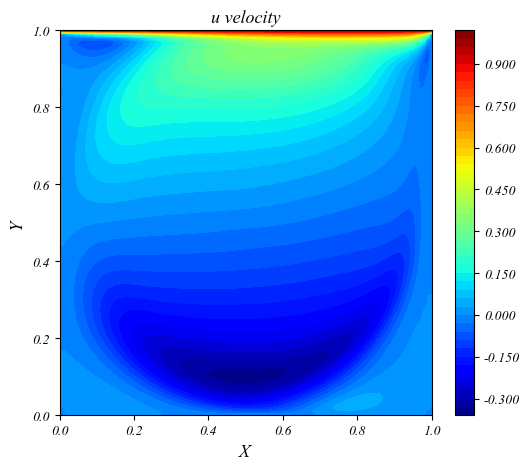

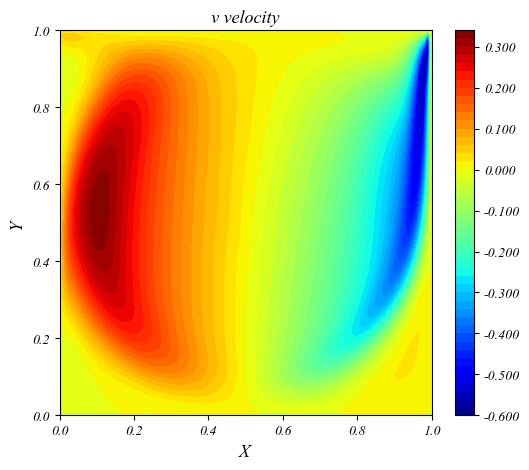

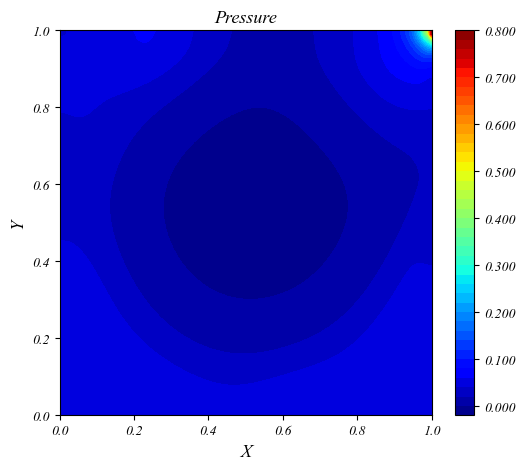

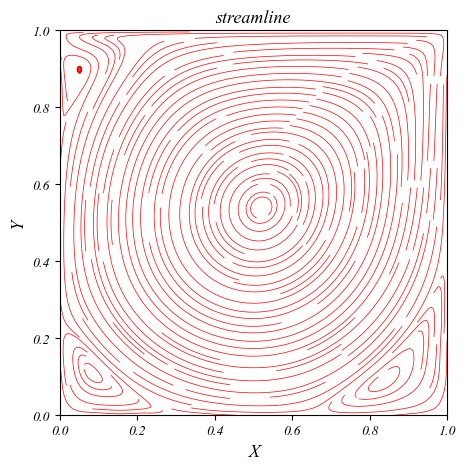

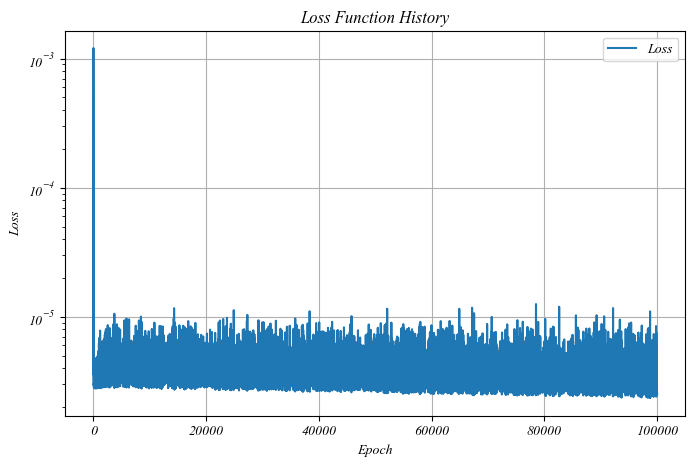

In [69]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/Cavity Ra=3200/4-FF-FD-PINNs-gated-avtivated-initialized/model'))
net.train(num_epochs=100000)
net.plot()
net.plot_loss()

In [70]:
# Given validation data for R=3200
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.32407, -0.35344, -0.37827, -0.41933, -0.34323, -0.24427, -0.086636, -0.04272,
                          0.07156, 0.19791, 0.34682, 0.46101, 0.46547, 0.48296, 0.53236, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.39560, 0.40917, 0.41906, 0.42768, 0.37119, 0.29030, 0.28188, 0.00999,
                          -0.31184, -0.37401, -0.44307, -0.54053, -0.52357, -0.47425, -0.39017, 0])

In [38]:
# Given validation data for R=1000
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648,
                          -0.06080, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526,
                          -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669, -0.21388, 0])

In [27]:
# Given validation data for R=100
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.03717, -0.04192, -0.04775, -0.06434, -0.1015, -0.15662, -0.21090,
                          -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454,
                          -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0])

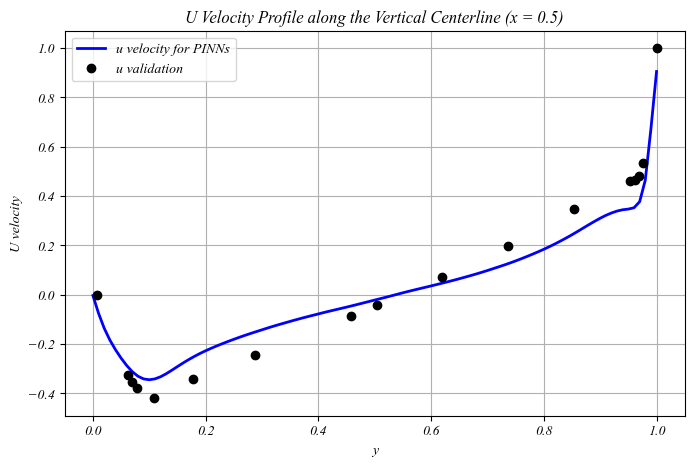

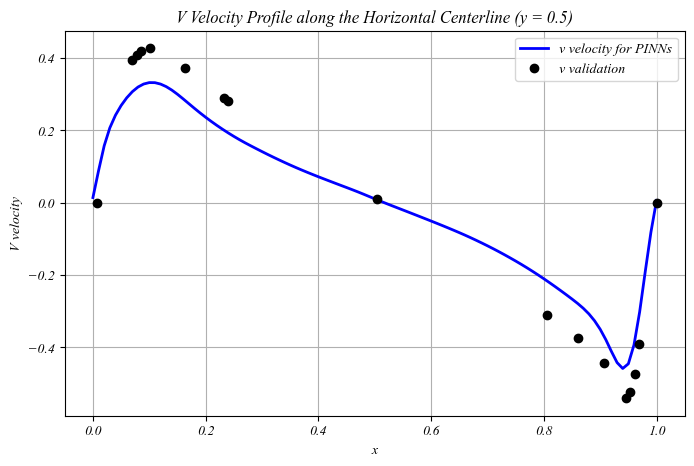

In [72]:
with torch.no_grad():
    uvp_pred = net.network(net.X).reshape(len(net.x), len(net.y), 3)

u = uvp_pred[:, :, 0].detach().cpu().numpy()
v = uvp_pred[:, :, 1].detach().cpu().numpy()

# Plot u velocity along vertical centerline (x = 0.5)
plt.figure(figsize=(8, 5))
center_idx_x = len(net.x) // 2
plt.plot(net.y.cpu(), u[center_idx_x, :], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

# Plot v velocity along horizontal centerline (y = 0.5)
plt.figure(figsize=(8, 5))
center_idx_y = len(net.y) // 2
plt.plot(net.x.cpu(), v[:, center_idx_y], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()